# RNA preentrenadas III
## (Torch Hub)
___

En el siguiente ejemplo vamos a experimentar con una la red SSED (_Single Shot MultiBox Detector_) de NVIDIA

Cargaremos el modelo, previamente entrenado a partir del _dataset_ COCO, directamente desde **Torch Hub**, un repositorio de modelos de pyTorch

En primer lugar, descargaremos una serie de utilidades que faciitaran el formatead de la entrada y salida del modelo

In [1]:
import torch

utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd_processing_utils')

Downloading: "https://github.com/NVIDIA/DeepLearningExamples/archive/torchhub.zip" to /home/zeroth/.cache/torch/hub/torchhub.zip


Creamos nuestro modelo a partir del modelo de NVIDIA en el repositorio

In [3]:
precision = 'fp32'
ssd_model = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_ssd', model_math=precision)

Using cache found in /home/zeroth/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/zeroth/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
24.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

55.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

86.8%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in orde

Ahora, preparamos el modelo para la inferencia

In [4]:
ssd_model.to('cuda')
ssd_model.eval()

SSD300(
  (feature_extractor): ResNet(
    (feature_extractor): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

Preparamos varias imágenes para la detección de objetos (en el ejemplo, son arias imágenes correspondientes al COCO dataset)

In [66]:
uris = [
    'http://images.cocodataset.org/val2017/000000397133.jpg',
    'http://images.cocodataset.org/val2017/000000037777.jpg',
    'http://images.cocodataset.org/val2017/000000252219.jpg',
    'https://novakdjokovicfoundation.org/wp-content/uploads/2015/04/son-playing-ball-in-the-park.jpg',
    'http://www.officialteamlift.com/wp-content/uploads/2017/03/fruit_selection_155265101_web.jpg'
]

Formateamos las imágenes para ajustarlas a la entrada esperada por la red y las convertimos en tensores

In [76]:
inputs = [utils.prepare_input(uri) for uri in uris]
tensor = utils.prepare_tensor(inputs, precision == 'fp16')

Ejecutamos la red para realizar la detección de objetos

In [77]:
with torch.no_grad():
    detections_batch = ssd_model(tensor)

Por defecto, la salida de la red SSD por imagen contiene 8732 cajas con localizaciones y distribuciones de probabilidades de las clases. Vamos a filtrar la salida para obtener sólo aquellas detecciones razonables (confianza>40%)

In [78]:
results_per_input = utils.decode_results(detections_batch)
best_results_per_input = [utils.pick_best(results, 0.40) for results in results_per_input]

El modelo fue entrenado en el COCO dataset, por lo que vamos a descargar los nombres de sus clases para traducir los ID's de los resultados

In [79]:
classes_to_labels = utils.get_coco_object_dictionary()

Y, por último, vamos a visualizar las detecciones

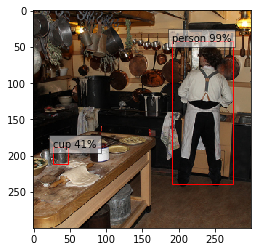

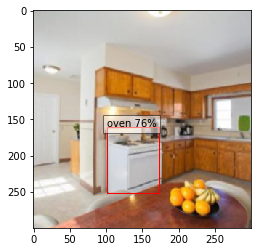

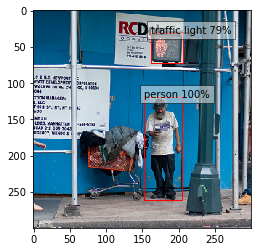

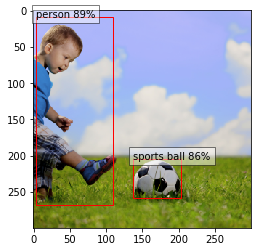

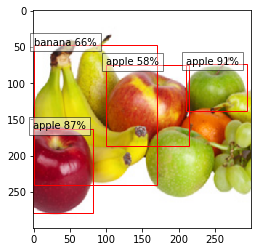

In [80]:
from matplotlib import pyplot as plt
import matplotlib.patches as patches

for image_idx in range(len(best_results_per_input)):
    fig, ax = plt.subplots(1)
    # show original, denormalized image...
    image = inputs[image_idx]/2 + 0.5
    ax.imshow(image)
    # with detections
    bboxes, classes, confidences = best_results_per_input[image_idx]
    for idx in range(len(bboxes)):
        left, bot, right, top = bboxes[idx]
        x, y, w, h = [val*300 for val in [left, bot, right - left, top - bot]]
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y, f"{classes_to_labels[classes[idx] - 1]} {confidences[idx]*100:.0f}%", bbox=dict(facecolor='white', alpha=0.5))        
plt.show()            